## Implementation
- Signal Smoothing with Median
- Slding Windowing : Every 100 windows  (50Hz * 2); stride of 50 => sample every 2 seconds
- Cascade Training
      - Binary Classifier : Resting vs Exercise (0 vs 1)
      - Multi Classifier  : Exercise Intensity (0 , 1, 2)
- Evaluation : Classification report -> cascade the results

## Changes
- Implemented Subject-wise actiivty downsampling for Majority Class to be the same as minor class - preserved temporal order
- Remove Subject 9

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import matplotlib.pyplot as plt

In [ ]:
import os
data_path = '/content/drive/My Drive/UofT/AppliedML/Datathon4/dataset/'
#source_df = pd.read_csv(data_path + 'Datathon #4 - mhealth Dataset - HAD7001.csv')
source_df = pd.read_csv('Datathon #4 - mhealth Dataset - HAD7001.csv')
source_df.head()


,alx,aly,alz,glx,gly,glz,arx,ary,arz,grx,gry,grz,Activity,subject
0,2.1849,-9.6967,0.63077,0.103900,-0.84053,-0.68762,-8.6499,-4.5781,0.187760,-0.44902,-1.0103,0.034483,0,subject1
1,2.3876,-9.5080,0.68389,0.085343,-0.83865,-0.68369,-8.6275,-4.3198,0.023595,-0.44902,-1.0103,0.034483,0,subject1
2,2.4086,-9.5674,0.68113,0.085343,-0.83865,-0.68369,-8.5055,-4.2772,0.275720,-0.44902,-1.0103,0.034483,0,subject1
3,2.1814,-9.4301,0.55031,0.085343,-0.83865,-0.68369,-8.6279,-4.3163,0.367520,-0.45686,-1.0082,0.025862,0,subject1
4,2.4173,-9.3889,0.71098,0.085343,-0.83865,-0.68369,-8.7008,-4.1459,0.407290,-0.45686,-1.0082,0.025862,0,subject1


In [ ]:
activity_10_mapping = {
    0: "Resting", 1: "Standing still (1 min)", 2: "Sitting and relaxing (1 min)",
    3: "Lying down (1 min)", 4: "Walking (1 min)", 5: "Climbing stairs (1 min)",
    6: "Waist bends forward (x20)", 7: "Frontal elevation of arms (x20)",
    8: "Knees bending (crouching) (x20)", 9: "Cycling (1 min)", 10: "Jogging (1 min)",
    11: "Running (1 min)", 12: "Jump front & back (x20)" }

activity_mapping = {
    0: "Resting", 1: "Resting", 2: "Resting", 3: "Resting",
    4: "LowIntensityExercise", 5: "ModerateIntensityExercise",
    6: "ModerateIntensityExercise", 7: "ModerateIntensityExercise",
    8: "ModerateIntensityExercise", 9: "ModerateIntensityExercise",
    10: "HighIntensityExercise", 11: "HighIntensityExercise",
    12: "HighIntensityExercise" }

activity_map = {
    "Resting": 0, "LowIntensityExercise": 1, "ModerateIntensityExercise": 2, "HighIntensityExercise": 3}

source_df['activity_10_category'] = source_df['Activity'].map(activity_10_mapping)
source_df['activity_category'] = source_df['Activity'].map(activity_mapping)

activity_summary = source_df['activity_category'].value_counts()
num_subjects = source_df['subject'].nunique()

features = [
    'accel_left_x', 'accel_left_y', 'accel_left_z', 'gyro_left_x', 'gyro_left_y', 'gyro_left_z',
    'accel_right_x', 'accel_right_y', 'accel_right_z', 'gyro_right_x', 'gyro_right_y', 'gyro_right_z' ]

column_names = features +  [ "activity", "subject", "activity_10_category", "activity_category"]

source_df.columns = column_names
print("After Renaming")
print(source_df.columns)

# Drop unnecessay columns ==> just use activity as our first experiment
source_df = source_df.drop(columns = ['activity_10_category','activity'])

source_df['idx'] = source_df.index
result = source_df.groupby(["subject", "activity_category"])["idx"].agg(["min", "max"])

After Renaming
Index(['accel_left_x', 'accel_left_y', 'accel_left_z', 'gyro_left_x',
       'gyro_left_y', 'gyro_left_z', 'accel_right_x', 'accel_right_y',
       'accel_right_z', 'gyro_right_x', 'gyro_right_y', 'gyro_right_z',
       'activity', 'subject', 'activity_10_category', 'activity_category'],
      dtype='object')


In [ ]:
source_df.head(4)

,accel_left_x,accel_left_y,accel_left_z,gyro_left_x,gyro_left_y,gyro_left_z,accel_right_x,accel_right_y,accel_right_z,gyro_right_x,gyro_right_y,gyro_right_z,subject,activity_category,idx
0,2.1849,-9.6967,0.63077,0.103900,-0.84053,-0.68762,-8.6499,-4.5781,0.187760,-0.44902,-1.0103,0.034483,subject1,Resting,0
1,2.3876,-9.5080,0.68389,0.085343,-0.83865,-0.68369,-8.6275,-4.3198,0.023595,-0.44902,-1.0103,0.034483,subject1,Resting,1
2,2.4086,-9.5674,0.68113,0.085343,-0.83865,-0.68369,-8.5055,-4.2772,0.275720,-0.44902,-1.0103,0.034483,subject1,Resting,2
3,2.1814,-9.4301,0.55031,0.085343,-0.83865,-0.68369,-8.6279,-4.3163,0.367520,-0.45686,-1.0082,0.025862,subject1,Resting,3


In [ ]:
source_df.activity_category.value_counts()

activity_category
Resting                      798576
ModerateIntensityExercise    119452
HighIntensityExercise         57395
LowIntensityExercise          24576
Name: count, dtype: int64

In [ ]:
source_df['activity'] = source_df['activity_category'].map(activity_map)
source_df.activity.value_counts()

activity
0    798576
2    119452
3     57395
1     24576
Name: count, dtype: int64

In [ ]:
#train_df = source_df[~source_df['subject'].isin(['subject5', 'subject6'])]
#test_df = source_df[source_df['subject'].isin(['subject5', 'subject6'])]

# Get the unique subjects in the dataset
unique_subjects = source_df['subject'].unique()
print(unique_subjects)

#train_ratio = 0.8
#val_ratio = 0.1
#test_ratio = 0.1

#num_train = int(len(unique_subjects) * train_ratio)
#num_test = int(len(unique_subjects) * test_ratio)
#num_val = int(len(unique_subjects) * val_ratio)
#num_train, num_test, num_val

def to_tensor(X, y):
    return torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.long)


['subject1' 'subject2' 'subject3' 'subject4' 'subject5' 'subject6'
 'subject7' 'subject8' 'subject9']


### We gonna build Cascade Classification

- Binaray Classification ( Resting vs Exercises)
- Exercies (Low , Moderate, High)

In [ ]:
train_subjects = ['subject1', 'subject2', 'subject3', 'subject4', 'subject7', 'subject8' ]
val_subjects = ['subject5']
test_subjects = ['subject6']

def split_bysubs(source_df, train_subjects, val_subjects, test_subjects):
    train_df = source_df[source_df['subject'].isin(train_subjects)]
    val_df = source_df[source_df['subject'].isin(val_subjects)]
    test_df = source_df[source_df['subject'].isin(test_subjects)]
    return train_df, val_df, test_df


first_step_df = source_df.copy()
second_step_df = source_df.copy()


In [ ]:
first_step_df.head(3)

,accel_left_x,accel_left_y,accel_left_z,gyro_left_x,gyro_left_y,gyro_left_z,accel_right_x,accel_right_y,accel_right_z,gyro_right_x,gyro_right_y,gyro_right_z,subject,activity_category,idx,activity
0,2.1849,-9.6967,0.63077,0.103900,-0.84053,-0.68762,-8.6499,-4.5781,0.187760,-0.44902,-1.0103,0.034483,subject1,Resting,0,0
1,2.3876,-9.5080,0.68389,0.085343,-0.83865,-0.68369,-8.6275,-4.3198,0.023595,-0.44902,-1.0103,0.034483,subject1,Resting,1,0
2,2.4086,-9.5674,0.68113,0.085343,-0.83865,-0.68369,-8.5055,-4.2772,0.275720,-0.44902,-1.0103,0.034483,subject1,Resting,2,0


In [ ]:
first_step_df.activity_category.value_counts()

activity_category
Resting                      798576
ModerateIntensityExercise    119452
HighIntensityExercise         57395
LowIntensityExercise          24576
Name: count, dtype: int64

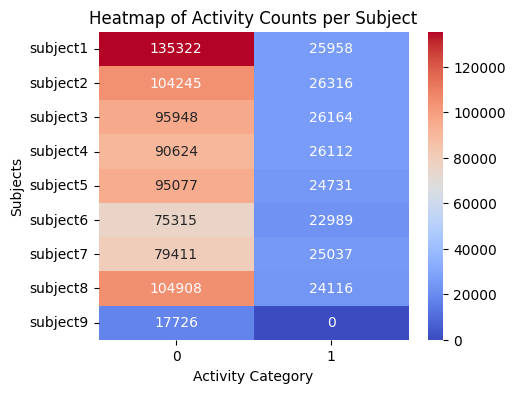

In [ ]:
first_step_df['activity'] = first_step_df['activity_category'].apply(lambda x: 0 if x == 'Resting' else 1)
count_per_subject1 = first_step_df.groupby(["subject", "activity"]).size().unstack(fill_value=0)
plt.figure(figsize=(5,4))
sns.heatmap(count_per_subject1, annot=True, cmap="coolwarm", fmt="d")
plt.xlabel("Activity Category")
plt.ylabel("Subjects")
plt.title("Heatmap of Activity Counts per Subject")
plt.show()

In [ ]:
def stratified_downsample_ordered(df, time_column):
    downsampled_df = pd.DataFrame()

    for subject, group in df.groupby("subject"):
        activity_counts = group["activity"].value_counts()
        min_count = activity_counts.min()  # Find the minority class count

        sampled_groups = []
        for activity in activity_counts.index:
            activity_group = group[group["activity"] == activity].sort_values(time_column)  # Ensure temporal order
            if len(activity_group) > min_count:
                downsampled_group = activity_group.iloc[:min_count]  # Select first `min_count` elements
            else:
                downsampled_group = activity_group  # Keep as is if already at min count

            sampled_groups.append(downsampled_group)

        balanced_subject_df = pd.concat(sampled_groups)
        downsampled_df = pd.concat([downsampled_df, balanced_subject_df])

    return downsampled_df


### Downsample the data

In [ ]:
time_column = "idx"#assume index is the timestep
first_step_sampled_df = stratified_downsample_ordered(first_step_df, time_column="idx")


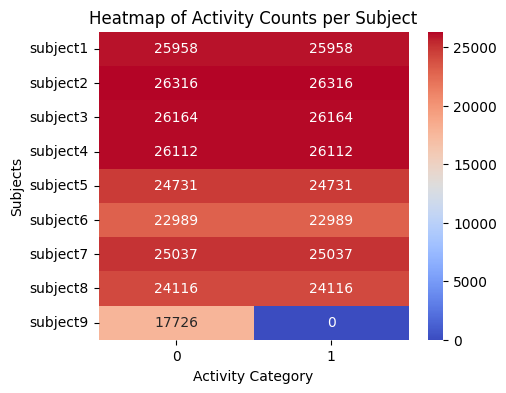

In [ ]:
count_per_subject1_ = first_step_sampled_df.groupby(["subject", "activity"]).size().unstack(fill_value=0)
plt.figure(figsize=(5,4))
sns.heatmap(count_per_subject1_, annot=True, cmap="coolwarm", fmt="d")
plt.xlabel("Activity Category")
plt.ylabel("Subjects")
plt.title("Heatmap of Activity Counts per Subject")
plt.show()

In [ ]:
print('before', second_step_df['activity_category'].value_counts())
second_step_df = second_step_df[~(second_step_df['activity_category'] == 'Resting')]
#second_step_df = second_step_df[~(second_step_df['activity_category'].isin(['Resting', 'LowIntensityExercise']))]
print('after')
second_step_df['activity_category'].value_counts()

before activity_category
Resting                      798576
ModerateIntensityExercise    119452
HighIntensityExercise         57395
LowIntensityExercise          24576
Name: count, dtype: int64
after


activity_category
ModerateIntensityExercise    119452
HighIntensityExercise         57395
LowIntensityExercise          24576
Name: count, dtype: int64

In [ ]:
activity_map

{'Resting': 0,
 'LowIntensityExercise': 1,
 'ModerateIntensityExercise': 2,
 'HighIntensityExercise': 3}

In [ ]:
second_activity_map = {
    "LowIntensityExercise": 0, "ModerateIntensityExercise": 1, "HighIntensityExercise": 2}

In [ ]:
second_step_df['activity'] = second_step_df['activity_category'].map(second_activity_map) # activity_map
second_step_df.activity.value_counts()

activity
1    119452
2     57395
0     24576
Name: count, dtype: int64

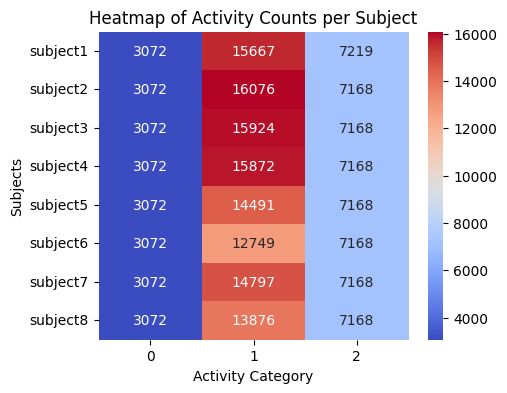

In [ ]:
count_per_subject2 = second_step_df.groupby(["subject", "activity"]).size().unstack(fill_value=0)
plt.figure(figsize=(5,4))
sns.heatmap(count_per_subject2, annot=True, cmap="coolwarm", fmt="d")
plt.xlabel("Activity Category")
plt.ylabel("Subjects")
plt.title("Heatmap of Activity Counts per Subject")
plt.show()

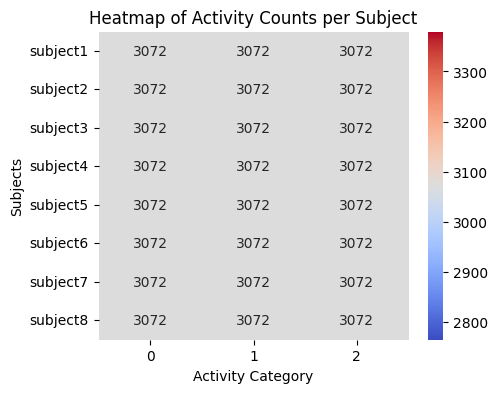

In [ ]:
time_column = "idx"#assume index is the timestep
second_step_sampled_df = stratified_downsample_ordered(second_step_df, time_column="idx")
count_per_subject2_ = second_step_sampled_df.groupby(["subject", "activity"]).size().unstack(fill_value=0)
plt.figure(figsize=(5,4))
sns.heatmap(count_per_subject2_, annot=True, cmap="coolwarm", fmt="d")
plt.xlabel("Activity Category")
plt.ylabel("Subjects")
plt.title("Heatmap of Activity Counts per Subject")
plt.show()

In [ ]:
first_step_sampled_df.shape, second_step_sampled_df.shape

((420572, 16), (73728, 16))

In [ ]:
#first_train_df, first_val_df, first_test_df = split_bysubs(first_step_df, train_subjects, val_subjects, test_subjects)
first_train_df, first_val_df, first_test_df = split_bysubs(first_step_sampled_df, train_subjects, val_subjects, test_subjects)


second_train_df, second_val_df, second_test_df = split_bysubs(second_step_df, train_subjects, val_subjects, test_subjects)
#second_train_df, second_val_df, second_test_df = split_bysubs(second_step_sampled_df, train_subjects, val_subjects, test_subjects)

source_df['activity'] =   source_df['activity_category'].map(activity_map)
_, _, test_df = split_bysubs(source_df, train_subjects, val_subjects, test_subjects)

In [ ]:
features

['accel_left_x',
 'accel_left_y',
 'accel_left_z',
 'gyro_left_x',
 'gyro_left_y',
 'gyro_left_z',
 'accel_right_x',
 'accel_right_y',
 'accel_right_z',
 'gyro_right_x',
 'gyro_right_y',
 'gyro_right_z']

In [ ]:
features_median = [f"{feature}_median" for feature in features]
features_median

['accel_left_x_median',
 'accel_left_y_median',
 'accel_left_z_median',
 'gyro_left_x_median',
 'gyro_left_y_median',
 'gyro_left_z_median',
 'accel_right_x_median',
 'accel_right_y_median',
 'accel_right_z_median',
 'gyro_right_x_median',
 'gyro_right_y_median',
 'gyro_right_z_median']

In [ ]:
# X = features , y = activity
def create_windows1(df, window_size=100, step_size=50):
    sequences, labels = [], []

    for subj in df['subject'].unique():
        print('sub ', subj)
        subj_df = df[df['subject'] == subj]
        for act in subj_df['activity'].unique():
            act_df = subj_df[subj_df['activity'] == act]
            display(act_df.head(2))

            for i in range(0, len(act_df) - window_size, step_size):
                window = act_df.iloc[i:i+window_size]
                sequences.append(window[features].values)  # Only use selected features
                labels.append(act)

    return np.array(sequences), np.array(labels)


def create_windows(df, window_size=100, step_size=50):
    sequences, labels = [], []

    for subj in df['subject'].unique():
        print(f'Processing subject {subj}')
        subj_df = df[df['subject'] == subj]

        for act in subj_df['activity'].unique():
            print(f'  Activity: {act}')

            act_df = subj_df[subj_df['activity'] == act].copy()
            #print('before')
            display(act_df.head(2))
            for feature in features:
                act_df[f'{feature}_median'] = act_df[feature].rolling(window=3, min_periods=1).median()
            #print('after')
            #display(act_df.head(2))
            # Drop NaN values created by rolling operation
            act_df = act_df.dropna()

            # Create overlapping windows
            for i in range(0, len(act_df) - window_size + 1, step_size):
                window = act_df.iloc[i:i+window_size]
                #display(window[features_median].head(2))

                sequences.append(window[features_median].values)
                labels.append(act)

    return np.array(sequences), np.array(labels)


In [ ]:
#X_train1, y_train1 = create_windows(first_train_df.copy())

In [ ]:
# Create time windows
X_train1, y_train1 = create_windows(first_train_df)
X_val1, y_val1 = create_windows(first_val_df)
X_test1, y_test1 = create_windows(first_test_df)
first_train_df.head(1)

Processing subject subject1
  Activity: 0


,accel_left_x,accel_left_y,accel_left_z,gyro_left_x,gyro_left_y,gyro_left_z,accel_right_x,accel_right_y,accel_right_z,gyro_right_x,gyro_right_y,gyro_right_z,subject,activity_category,idx,activity
0,2.1849,-9.6967,0.63077,0.103900,-0.84053,-0.68762,-8.6499,-4.5781,0.187760,-0.44902,-1.0103,0.034483,subject1,Resting,0,0
1,2.3876,-9.5080,0.68389,0.085343,-0.83865,-0.68369,-8.6275,-4.3198,0.023595,-0.44902,-1.0103,0.034483,subject1,Resting,1,0


  Activity: 1


,accel_left_x,accel_left_y,accel_left_z,gyro_left_x,gyro_left_y,gyro_left_z,accel_right_x,accel_right_y,accel_right_z,gyro_right_x,gyro_right_y,gyro_right_z,subject,activity_category,idx,activity
28160,4.3791,-10.2060,0.14805,0.59184,-0.52345,0.48919,-7.0015,-10.089,3.0789,-0.57647,-0.59959,0.75431,subject1,LowIntensityExercise,28160,1
28161,5.4713,-9.5863,-0.21627,0.62338,-0.55347,0.39489,-6.3209,-10.026,2.3737,-0.57647,-0.59959,0.75431,subject1,LowIntensityExercise,28161,1


Processing subject subject2
  Activity: 0


,accel_left_x,accel_left_y,accel_left_z,gyro_left_x,gyro_left_y,gyro_left_z,accel_right_x,accel_right_y,accel_right_z,gyro_right_x,gyro_right_y,gyro_right_z,subject,activity_category,idx,activity
161280,0.49965,-9.6680,1.5216,-0.47866,-0.53471,0.53438,-4.6451,-8.2508,1.9208,-0.98039,-0.41889,0.18966,subject2,Resting,161280,0
161281,0.40572,-9.5801,1.4001,-0.48423,-0.54409,0.52652,-4.7847,-8.2609,1.9099,-0.98039,-0.41889,0.18966,subject2,Resting,161281,0


  Activity: 1


,accel_left_x,accel_left_y,accel_left_z,gyro_left_x,gyro_left_y,gyro_left_z,accel_right_x,accel_right_y,accel_right_z,gyro_right_x,gyro_right_y,gyro_right_z,subject,activity_category,idx,activity
175872,0.18314,-9.4906,-6.4831,-0.26716,-0.38649,0.174850,-3.4535,-10.677,2.3412,-0.41176,-0.40452,0.012931,subject2,ModerateIntensityExercise,175872,1
175873,0.82168,-7.3844,-3.7881,-0.34323,-0.49531,0.013752,-3.6900,-10.950,1.9837,-0.37059,-0.41478,-0.049569,subject2,ModerateIntensityExercise,175873,1


Processing subject subject3
  Activity: 0


,accel_left_x,accel_left_y,accel_left_z,gyro_left_x,gyro_left_y,gyro_left_z,accel_right_x,accel_right_y,accel_right_z,gyro_right_x,gyro_right_y,gyro_right_z,subject,activity_category,idx,activity
291841,-0.18848,-9.8425,0.90183,0.55659,-0.8349,0.062868,-9.0897,2.0431,1.3105,-0.7549,-0.22998,0.78233,subject3,Resting,291841,0
291842,-0.36263,-9.7832,0.89263,0.55659,-0.8349,0.062868,-9.6010,1.8242,1.4245,-0.7549,-0.22998,0.78233,subject3,Resting,291842,0


  Activity: 1


,accel_left_x,accel_left_y,accel_left_z,gyro_left_x,gyro_left_y,gyro_left_z,accel_right_x,accel_right_y,accel_right_z,gyro_right_x,gyro_right_y,gyro_right_z,subject,activity_category,idx,activity
316417,-1.0745,-13.531,-1.5935,0.31354,-0.42777,0.75049,-1.0525,-12.986,0.413210,-0.40196,-0.39014,0.96983,subject3,LowIntensityExercise,316417,1
316418,3.3296,-12.795,-3.3044,0.31354,-0.42777,0.75049,-1.0675,-13.400,0.048774,-0.40196,-0.39014,0.96983,subject3,LowIntensityExercise,316418,1


Processing subject subject4
  Activity: 0


,accel_left_x,accel_left_y,accel_left_z,gyro_left_x,gyro_left_y,gyro_left_z,accel_right_x,accel_right_y,accel_right_z,gyro_right_x,gyro_right_y,gyro_right_z,subject,activity_category,idx,activity
413953,1.5686,-9.6207,0.30548,-0.80891,-0.81238,0.35756,-6.7368,-6.6124,2.7631,-1.2333,-0.47844,-0.051724,subject4,Resting,413953,0
413954,1.4369,-9.8798,0.13496,-0.80148,-0.81989,0.35167,-6.4254,-6.5098,3.0183,-1.2333,-0.47844,-0.051724,subject4,Resting,413954,0


  Activity: 1


,accel_left_x,accel_left_y,accel_left_z,gyro_left_x,gyro_left_y,gyro_left_z,accel_right_x,accel_right_y,accel_right_z,gyro_right_x,gyro_right_y,gyro_right_z,subject,activity_category,idx,activity
416257,-0.92331,-6.8344,-3.2468,-0.51948,-0.41839,-0.033399,-2.4757,-9.5828,0.71878,-0.35686,-0.44148,-0.036638,subject4,ModerateIntensityExercise,416257,1
416258,-0.54625,-7.7650,-4.2270,-0.48237,-0.33959,0.041257,-2.5240,-9.5734,0.65675,-0.35686,-0.44148,-0.036638,subject4,ModerateIntensityExercise,416258,1


Processing subject subject7
  Activity: 0


,accel_left_x,accel_left_y,accel_left_z,gyro_left_x,gyro_left_y,gyro_left_z,accel_right_x,accel_right_y,accel_right_z,gyro_right_x,gyro_right_y,gyro_right_z,subject,activity_category,idx,activity
748801,2.3448,-9.6597,1.3530,0.78108,-0.52158,-0.049116,-7.0806,-6.6875,2.2490,-0.64902,-0.13758,0.82328,subject7,Resting,748801,0
748802,2.0888,-9.4906,1.4318,0.77922,-0.52533,-0.039293,-6.8389,-6.5352,2.4753,-0.64902,-0.13758,0.82328,subject7,Resting,748802,0


  Activity: 1


,accel_left_x,accel_left_y,accel_left_z,gyro_left_x,gyro_left_y,gyro_left_z,accel_right_x,accel_right_y,accel_right_z,gyro_right_x,gyro_right_y,gyro_right_z,subject,activity_category,idx,activity
754945,1.1989,-9.4540,-2.8253,0.58627,-0.58349,-0.49312,-0.29813,-11.2500,4.0208,0.33725,-0.82957,0.1444,subject7,ModerateIntensityExercise,754945,1
754946,1.0244,-9.7751,-3.2493,0.59740,-0.57786,-0.49116,0.62480,-9.9551,3.4918,0.37647,-0.83984,0.1250,subject7,ModerateIntensityExercise,754946,1


Processing subject subject8
  Activity: 0


,accel_left_x,accel_left_y,accel_left_z,gyro_left_x,gyro_left_y,gyro_left_z,accel_right_x,accel_right_y,accel_right_z,gyro_right_x,gyro_right_y,gyro_right_z,subject,activity_category,idx,activity
853249,-0.56999,-9.8471,-1.5397,-0.14657,-0.16886,0.76228,-2.1972,-9.4860,-0.59930,-0.69412,-0.28131,-0.42457,subject8,Resting,853249,0
853250,-0.41798,-9.7781,-1.5764,-0.14657,-0.16886,0.76228,-1.9841,-9.6963,-0.63065,-0.69020,-0.27310,-0.44181,subject8,Resting,853250,0


  Activity: 1


,accel_left_x,accel_left_y,accel_left_z,gyro_left_x,gyro_left_y,gyro_left_z,accel_right_x,accel_right_y,accel_right_z,gyro_right_x,gyro_right_y,gyro_right_z,subject,activity_category,idx,activity
891649,1.8375,-11.798,-2.5403,-0.43228,-0.66604,-0.75835,-4.1340,-10.467,0.28914,0.14118,-0.93429,-0.57112,subject8,LowIntensityExercise,891649,1
891650,1.1844,-13.877,-2.5779,-0.43228,-0.66604,-0.75835,-4.5149,-10.985,-0.50759,0.14118,-0.93429,-0.57112,subject8,LowIntensityExercise,891650,1


Processing subject subject5
  Activity: 0


,accel_left_x,accel_left_y,accel_left_z,gyro_left_x,gyro_left_y,gyro_left_z,accel_right_x,accel_right_y,accel_right_z,gyro_right_x,gyro_right_y,gyro_right_z,subject,activity_category,idx,activity
530689,0.39931,-9.4774,-2.1990,0.087199,-0.70544,-0.82711,-1.4596,-10.2560,-2.5961,0.38431,-0.86653,-0.65517,subject5,Resting,530689,0
530690,1.08420,-8.8761,-1.4746,0.087199,-0.70544,-0.82711,-1.6157,-9.6925,-2.2450,0.38431,-0.86653,-0.65517,subject5,Resting,530690,0


  Activity: 1


,accel_left_x,accel_left_y,accel_left_z,gyro_left_x,gyro_left_y,gyro_left_z,accel_right_x,accel_right_y,accel_right_z,gyro_right_x,gyro_right_y,gyro_right_z,subject,activity_category,idx,activity
547585,-6.4982,-11.267,-1.8991,-0.118740,-0.93058,-0.44794,2.3567,-11.507,-1.7212,-0.15294,-1.0986,-0.18103,subject5,LowIntensityExercise,547585,1
547586,-2.2589,-12.632,-1.7896,-0.046382,-0.86116,-0.60314,1.2439,-11.450,-1.9787,-0.15294,-1.0986,-0.18103,subject5,LowIntensityExercise,547586,1


Processing subject subject6
  Activity: 0


,accel_left_x,accel_left_y,accel_left_z,gyro_left_x,gyro_left_y,gyro_left_z,accel_right_x,accel_right_y,accel_right_z,gyro_right_x,gyro_right_y,gyro_right_z,subject,activity_category,idx,activity
650497,-0.77206,-9.4262,-4.9999,0.25788,-0.90807,0.16896,-12.1360,-1.9945,0.54611,-0.5902,0.71663,0.31466,subject6,Resting,650497,0
650498,-4.59760,-9.2246,-2.6530,0.31354,-0.87992,0.18664,-9.2323,-1.5408,-1.07700,-0.5902,0.71663,0.31466,subject6,Resting,650498,0


  Activity: 1


,accel_left_x,accel_left_y,accel_left_z,gyro_left_x,gyro_left_y,gyro_left_z,accel_right_x,accel_right_y,accel_right_z,gyro_right_x,gyro_right_y,gyro_right_z,subject,activity_category,idx,activity
667393,2.5003,-9.3273,1.9232,0.022263,-0.90619,-0.51866,-2.1307,-9.1792,2.0827,-0.041176,-1.1088,-0.17026,subject6,LowIntensityExercise,667393,1
667394,2.9764,-9.0208,1.8808,0.022263,-0.90619,-0.51866,-2.3891,-8.7478,2.2189,0.062745,-1.0698,-0.26509,subject6,LowIntensityExercise,667394,1


,accel_left_x,accel_left_y,accel_left_z,gyro_left_x,gyro_left_y,gyro_left_z,accel_right_x,accel_right_y,accel_right_z,gyro_right_x,gyro_right_y,gyro_right_z,subject,activity_category,idx,activity
0,2.1849,-9.6967,0.63077,0.1039,-0.84053,-0.68762,-8.6499,-4.5781,0.18776,-0.44902,-1.0103,0.034483,subject1,Resting,0,0


In [ ]:
X_train1[0, 0, :]

array([ 2.1849  , -9.6967  ,  0.63077 ,  0.1039  , -0.84053 , -0.68762 ,
       -8.6499  , -4.5781  ,  0.18776 , -0.44902 , -1.0103  ,  0.034483])

In [ ]:
print("Shapes:", X_train1.shape, y_train1.shape, X_val1.shape, y_val1.shape, X_test1.shape, y_test1.shape)

Shapes: (6132, 100, 12) (6132,) (986, 100, 12) (986,) (916, 100, 12) (916,)


In [ ]:
# Create time windows
X_train2, y_train2 = create_windows(second_train_df)
X_val2, y_val2 = create_windows(second_val_df)
X_test2, y_test2 = create_windows(second_test_df)
second_train_df.head(1)

Processing subject subject1
  Activity: 0


,accel_left_x,accel_left_y,accel_left_z,gyro_left_x,gyro_left_y,gyro_left_z,accel_right_x,accel_right_y,accel_right_z,gyro_right_x,gyro_right_y,gyro_right_z,subject,activity_category,idx,activity
28160,4.3791,-10.2060,0.14805,0.59184,-0.52345,0.48919,-7.0015,-10.089,3.0789,-0.57647,-0.59959,0.75431,subject1,LowIntensityExercise,28160,0
28161,5.4713,-9.5863,-0.21627,0.62338,-0.55347,0.39489,-6.3209,-10.026,2.3737,-0.57647,-0.59959,0.75431,subject1,LowIntensityExercise,28161,0


  Activity: 1


,accel_left_x,accel_left_y,accel_left_z,gyro_left_x,gyro_left_y,gyro_left_z,accel_right_x,accel_right_y,accel_right_z,gyro_right_x,gyro_right_y,gyro_right_z,subject,activity_category,idx,activity
37376,0.147440,-9.8733,0.78906,-0.46382,-0.68668,0.47151,-5.6556,-8.2373,3.2652,-0.92353,-0.49076,0.21983,subject1,ModerateIntensityExercise,37376,1
37377,-0.025922,-9.9632,0.70991,-0.46382,-0.68668,0.47151,-4.7974,-8.4328,2.7242,-0.92353,-0.49076,0.21983,subject1,ModerateIntensityExercise,37377,1


  Activity: 2


,accel_left_x,accel_left_y,accel_left_z,gyro_left_x,gyro_left_y,gyro_left_z,accel_right_x,accel_right_y,accel_right_z,gyro_right_x,gyro_right_y,gyro_right_z,subject,activity_category,idx,activity
88064,2.1935,-18.368,-5.1361,0.56772,-0.803,-0.005894,-17.720,9.5017,-1.8270,-0.88824,0.4538,0.46767,subject1,HighIntensityExercise,88064,2
88065,-1.1953,-19.145,10.3020,0.56772,-0.803,-0.005894,-13.696,8.3210,1.1036,-0.88824,0.4538,0.46767,subject1,HighIntensityExercise,88065,2


Processing subject subject2
  Activity: 1


,accel_left_x,accel_left_y,accel_left_z,gyro_left_x,gyro_left_y,gyro_left_z,accel_right_x,accel_right_y,accel_right_z,gyro_right_x,gyro_right_y,gyro_right_z,subject,activity_category,idx,activity
175872,0.18314,-9.4906,-6.4831,-0.26716,-0.38649,0.174850,-3.4535,-10.677,2.3412,-0.41176,-0.40452,0.012931,subject2,ModerateIntensityExercise,175872,1
175873,0.82168,-7.3844,-3.7881,-0.34323,-0.49531,0.013752,-3.6900,-10.950,1.9837,-0.37059,-0.41478,-0.049569,subject2,ModerateIntensityExercise,175873,1


  Activity: 0


,accel_left_x,accel_left_y,accel_left_z,gyro_left_x,gyro_left_y,gyro_left_z,accel_right_x,accel_right_y,accel_right_z,gyro_right_x,gyro_right_y,gyro_right_z,subject,activity_category,idx,activity
223744,1.3102,-9.3341,0.25473,0.53247,-0.65291,0.41061,-2.4885,-7.8477,4.2326,-0.29412,-0.3039,1.0991,subject2,LowIntensityExercise,223744,0
223745,1.1711,-9.1302,0.83645,0.52690,-0.67355,0.38703,-2.2401,-8.7109,3.9082,-0.29412,-0.3039,1.0991,subject2,LowIntensityExercise,223745,0


  Activity: 2


,accel_left_x,accel_left_y,accel_left_z,gyro_left_x,gyro_left_y,gyro_left_z,accel_right_x,accel_right_y,accel_right_z,gyro_right_x,gyro_right_y,gyro_right_z,subject,activity_category,idx,activity
253440,-6.5160,-1.1278,-7.8299,0.53432,-0.7561,0.21611,5.1772,-4.9492,-0.92455,-0.29216,0.114990,1.0927,subject2,HighIntensityExercise,253440,2
253441,1.0477,-10.6940,-10.0030,0.53432,-0.7561,0.21611,4.1017,-5.4989,0.11047,-0.31176,0.069815,1.1056,subject2,HighIntensityExercise,253441,2


Processing subject subject3
  Activity: 0


,accel_left_x,accel_left_y,accel_left_z,gyro_left_x,gyro_left_y,gyro_left_z,accel_right_x,accel_right_y,accel_right_z,gyro_right_x,gyro_right_y,gyro_right_z,subject,activity_category,idx,activity
316417,-1.0745,-13.531,-1.5935,0.31354,-0.42777,0.75049,-1.0525,-12.986,0.413210,-0.40196,-0.39014,0.96983,subject3,LowIntensityExercise,316417,0
316418,3.3296,-12.795,-3.3044,0.31354,-0.42777,0.75049,-1.0675,-13.400,0.048774,-0.40196,-0.39014,0.96983,subject3,LowIntensityExercise,316418,0


  Activity: 1


,accel_left_x,accel_left_y,accel_left_z,gyro_left_x,gyro_left_y,gyro_left_z,accel_right_x,accel_right_y,accel_right_z,gyro_right_x,gyro_right_y,gyro_right_z,subject,activity_category,idx,activity
327271,-0.50421,-9.3815,2.4425,-0.43785,-0.59099,0.66601,-1.0713,-8.0162,-0.61956,-0.57255,-0.88912,0.31034,subject3,ModerateIntensityExercise,327271,1
327272,-0.74337,-9.3960,1.9811,-0.43785,-0.59099,0.66601,-2.1327,-8.6469,-0.69276,-0.57255,-0.88912,0.31034,subject3,ModerateIntensityExercise,327272,1


  Activity: 2


,accel_left_x,accel_left_y,accel_left_z,gyro_left_x,gyro_left_y,gyro_left_z,accel_right_x,accel_right_y,accel_right_z,gyro_right_x,gyro_right_y,gyro_right_z,subject,activity_category,idx,activity
355841,7.6448,-19.153,5.5355,-0.73655,0.095685,-0.8723,-3.2170,7.8063,1.62990,-0.20784,-1.0698,-0.22629,subject3,HighIntensityExercise,355841,2
355842,17.3690,-19.124,3.4467,-0.73655,0.095685,-0.8723,-3.4992,5.0628,0.28439,-0.20784,-1.0698,-0.22629,subject3,HighIntensityExercise,355842,2


Processing subject subject4
  Activity: 1


,accel_left_x,accel_left_y,accel_left_z,gyro_left_x,gyro_left_y,gyro_left_z,accel_right_x,accel_right_y,accel_right_z,gyro_right_x,gyro_right_y,gyro_right_z,subject,activity_category,idx,activity
416257,-0.92331,-6.8344,-3.2468,-0.51948,-0.41839,-0.033399,-2.4757,-9.5828,0.71878,-0.35686,-0.44148,-0.036638,subject4,ModerateIntensityExercise,416257,1
416258,-0.54625,-7.7650,-4.2270,-0.48237,-0.33959,0.041257,-2.5240,-9.5734,0.65675,-0.35686,-0.44148,-0.036638,subject4,ModerateIntensityExercise,416258,1


  Activity: 0


,accel_left_x,accel_left_y,accel_left_z,gyro_left_x,gyro_left_y,gyro_left_z,accel_right_x,accel_right_y,accel_right_z,gyro_right_x,gyro_right_y,gyro_right_z,subject,activity_category,idx,activity
471297,0.92177,-10.915,-0.36985,0.32468,-0.52345,0.64637,-0.48765,-9.7151,1.4934,0.056863,-0.66119,0.92888,subject4,LowIntensityExercise,471297,0
471298,1.05030,-10.528,0.61950,0.32468,-0.52345,0.64637,-0.40356,-10.1250,1.4937,0.056863,-0.66119,0.92888,subject4,LowIntensityExercise,471298,0


  Activity: 2


,accel_left_x,accel_left_y,accel_left_z,gyro_left_x,gyro_left_y,gyro_left_z,accel_right_x,accel_right_y,accel_right_z,gyro_right_x,gyro_right_y,gyro_right_z,subject,activity_category,idx,activity
514561,-4.0534,-18.5870,6.68640,-0.17625,-0.55159,-0.93320,-10.1040,-0.30109,4.8912,-0.63529,-0.85216,-0.21121,subject4,HighIntensityExercise,514561,2
514562,4.0630,-5.7372,-0.45456,-0.30612,-0.54597,-0.92731,-7.3262,1.73630,4.6285,-0.54118,-0.91581,-0.28664,subject4,HighIntensityExercise,514562,2


Processing subject subject7
  Activity: 1


,accel_left_x,accel_left_y,accel_left_z,gyro_left_x,gyro_left_y,gyro_left_z,accel_right_x,accel_right_y,accel_right_z,gyro_right_x,gyro_right_y,gyro_right_z,subject,activity_category,idx,activity
754945,1.1989,-9.4540,-2.8253,0.58627,-0.58349,-0.49312,-0.29813,-11.2500,4.0208,0.33725,-0.82957,0.1444,subject7,ModerateIntensityExercise,754945,1
754946,1.0244,-9.7751,-3.2493,0.59740,-0.57786,-0.49116,0.62480,-9.9551,3.4918,0.37647,-0.83984,0.1250,subject7,ModerateIntensityExercise,754946,1


  Activity: 0


,accel_left_x,accel_left_y,accel_left_z,gyro_left_x,gyro_left_y,gyro_left_z,accel_right_x,accel_right_y,accel_right_z,gyro_right_x,gyro_right_y,gyro_right_z,subject,activity_category,idx,activity
799489,1.5400,-9.8284,1.3156,0.09462,-0.57223,0.72692,-2.5711,-8.6575,4.2546,-0.1902,-0.42505,1.0259,subject7,LowIntensityExercise,799489,0
799490,1.5001,-9.7175,1.5187,0.09462,-0.57223,0.72692,-2.3087,-9.4888,4.1193,-0.1902,-0.42505,1.0259,subject7,LowIntensityExercise,799490,0


  Activity: 2


,accel_left_x,accel_left_y,accel_left_z,gyro_left_x,gyro_left_y,gyro_left_z,accel_right_x,accel_right_y,accel_right_z,gyro_right_x,gyro_right_y,gyro_right_z,subject,activity_category,idx,activity
830209,2.4901,-7.4082,-0.230930,-0.24861,0.011257,-1.1081,-21.621,-13.1660,15.415,-0.65294,-0.86858,0.099138,subject7,HighIntensityExercise,830209,2
830210,1.4640,-7.7038,-0.078881,-0.24861,0.011257,-1.1081,-19.686,-8.6458,12.422,-0.65294,-0.86858,0.099138,subject7,HighIntensityExercise,830210,2


Processing subject subject8
  Activity: 0


,accel_left_x,accel_left_y,accel_left_z,gyro_left_x,gyro_left_y,gyro_left_z,accel_right_x,accel_right_y,accel_right_z,gyro_right_x,gyro_right_y,gyro_right_z,subject,activity_category,idx,activity
891649,1.8375,-11.798,-2.5403,-0.43228,-0.66604,-0.75835,-4.1340,-10.467,0.28914,0.14118,-0.93429,-0.57112,subject8,LowIntensityExercise,891649,0
891650,1.1844,-13.877,-2.5779,-0.43228,-0.66604,-0.75835,-4.5149,-10.985,-0.50759,0.14118,-0.93429,-0.57112,subject8,LowIntensityExercise,891650,0


  Activity: 1


,accel_left_x,accel_left_y,accel_left_z,gyro_left_x,gyro_left_y,gyro_left_z,accel_right_x,accel_right_y,accel_right_z,gyro_right_x,gyro_right_y,gyro_right_z,subject,activity_category,idx,activity
900865,3.8242,-9.1114,-3.2194,0.68089,-0.58161,0.119840,-2.6723,-15.398,0.20927,-0.26863,-0.80698,0.72629,subject8,ModerateIntensityExercise,900865,1
900866,3.8082,-9.3170,-2.9903,0.69759,-0.59099,0.094303,-2.1485,-12.851,0.89912,-0.26863,-0.80698,0.72629,subject8,ModerateIntensityExercise,900866,1


  Activity: 2


,accel_left_x,accel_left_y,accel_left_z,gyro_left_x,gyro_left_y,gyro_left_z,accel_right_x,accel_right_y,accel_right_z,gyro_right_x,gyro_right_y,gyro_right_z,subject,activity_category,idx,activity
956161,4.4499,-19.329,-11.078,0.31354,-0.29644,-1.0334,6.6927,-18.549,4.0934,-0.76275,-0.74949,0.29310,subject8,HighIntensityExercise,956161,2
956162,5.9016,-19.438,-19.069,0.31354,-0.29644,-1.0334,13.9420,-16.722,4.8410,-0.93137,-0.50719,0.26509,subject8,HighIntensityExercise,956162,2


Processing subject subject5
  Activity: 0


,accel_left_x,accel_left_y,accel_left_z,gyro_left_x,gyro_left_y,gyro_left_z,accel_right_x,accel_right_y,accel_right_z,gyro_right_x,gyro_right_y,gyro_right_z,subject,activity_category,idx,activity
547585,-6.4982,-11.267,-1.8991,-0.118740,-0.93058,-0.44794,2.3567,-11.507,-1.7212,-0.15294,-1.0986,-0.18103,subject5,LowIntensityExercise,547585,0
547586,-2.2589,-12.632,-1.7896,-0.046382,-0.86116,-0.60314,1.2439,-11.450,-1.9787,-0.15294,-1.0986,-0.18103,subject5,LowIntensityExercise,547586,0


  Activity: 1


,accel_left_x,accel_left_y,accel_left_z,gyro_left_x,gyro_left_y,gyro_left_z,accel_right_x,accel_right_y,accel_right_z,gyro_right_x,gyro_right_y,gyro_right_z,subject,activity_category,idx,activity
555265,1.6843,-9.2170,2.0664,-0.60853,-0.74109,0.26916,-0.66613,-5.3368,-0.68351,-0.92157,-0.51129,0.092672,subject5,ModerateIntensityExercise,555265,1
555266,1.3095,-9.3741,2.1902,-0.63451,-0.71857,0.29273,-0.77205,-5.0392,-0.91863,-0.92157,-0.51129,0.092672,subject5,ModerateIntensityExercise,555266,1


  Activity: 2


,accel_left_x,accel_left_y,accel_left_z,gyro_left_x,gyro_left_y,gyro_left_z,accel_right_x,accel_right_y,accel_right_z,gyro_right_x,gyro_right_y,gyro_right_z,subject,activity_category,idx,activity
579841,7.0703,2.423,-18.100,-0.15028,-0.82927,-0.65619,-0.79522,-5.1710,1.8977,-1.0745,-0.12526,0.071121,subject5,HighIntensityExercise,579841,2
579842,2.7734,2.472,-18.151,-0.15028,-0.82927,-0.65619,1.02320,-5.7386,2.1402,-1.0745,-0.12526,0.071121,subject5,HighIntensityExercise,579842,2


Processing subject subject6
  Activity: 0


,accel_left_x,accel_left_y,accel_left_z,gyro_left_x,gyro_left_y,gyro_left_z,accel_right_x,accel_right_y,accel_right_z,gyro_right_x,gyro_right_y,gyro_right_z,subject,activity_category,idx,activity
667393,2.5003,-9.3273,1.9232,0.022263,-0.90619,-0.51866,-2.1307,-9.1792,2.0827,-0.041176,-1.1088,-0.17026,subject6,LowIntensityExercise,667393,0
667394,2.9764,-9.0208,1.8808,0.022263,-0.90619,-0.51866,-2.3891,-8.7478,2.2189,0.062745,-1.0698,-0.26509,subject6,LowIntensityExercise,667394,0


  Activity: 1


,accel_left_x,accel_left_y,accel_left_z,gyro_left_x,gyro_left_y,gyro_left_z,accel_right_x,accel_right_y,accel_right_z,gyro_right_x,gyro_right_y,gyro_right_z,subject,activity_category,idx,activity
675175,2.4871,-9.4806,0.45709,-0.14471,-0.85929,-0.58546,-1.8630,-11.474,0.59296,-0.21961,-0.90554,-0.51078,subject6,ModerateIntensityExercise,675175,1
675176,2.6444,-9.7864,0.56837,-0.14471,-0.86116,-0.59921,-2.0479,-11.705,0.49808,-0.21961,-0.90554,-0.51078,subject6,ModerateIntensityExercise,675176,1


  Activity: 2


,accel_left_x,accel_left_y,accel_left_z,gyro_left_x,gyro_left_y,gyro_left_z,accel_right_x,accel_right_y,accel_right_z,gyro_right_x,gyro_right_y,gyro_right_z,subject,activity_category,idx,activity
701185,7.0811,-4.0552,-18.392,0.16883,-0.35272,0.83104,6.5413,-7.8277,0.23362,-0.8098,0.067762,0.78448,subject6,HighIntensityExercise,701185,2
701186,14.7070,-3.2721,-18.298,0.16883,-0.35272,0.83104,6.0368,-7.1983,0.17134,-0.8098,0.067762,0.78448,subject6,HighIntensityExercise,701186,2


,accel_left_x,accel_left_y,accel_left_z,gyro_left_x,gyro_left_y,gyro_left_z,accel_right_x,accel_right_y,accel_right_z,gyro_right_x,gyro_right_y,gyro_right_z,subject,activity_category,idx,activity
28160,4.3791,-10.206,0.14805,0.59184,-0.52345,0.48919,-7.0015,-10.089,3.0789,-0.57647,-0.59959,0.75431,subject1,LowIntensityExercise,28160,0


In [ ]:
# Create time windows
X_train2[0, 0, :]

array([  4.3791 , -10.206  ,   0.14805,   0.59184,  -0.52345,   0.48919,
        -7.0015 , -10.089  ,   3.0789 ,  -0.57647,  -0.59959,   0.75431])

In [ ]:
print("Shapes:", X_train2.shape, y_train2.shape, X_val2.shape, y_val2.shape, X_test2.shape, y_test2.shape)

Shapes: (3048, 100, 12) (3048,) (490, 100, 12) (490,) (455, 100, 12) (455,)


In [ ]:
parcel1 = (X_train1, y_train1, X_val1, y_val1, X_test1, y_test1)
parcel2 = (X_train2, y_train2, X_val2, y_val2, X_test2, y_test2)

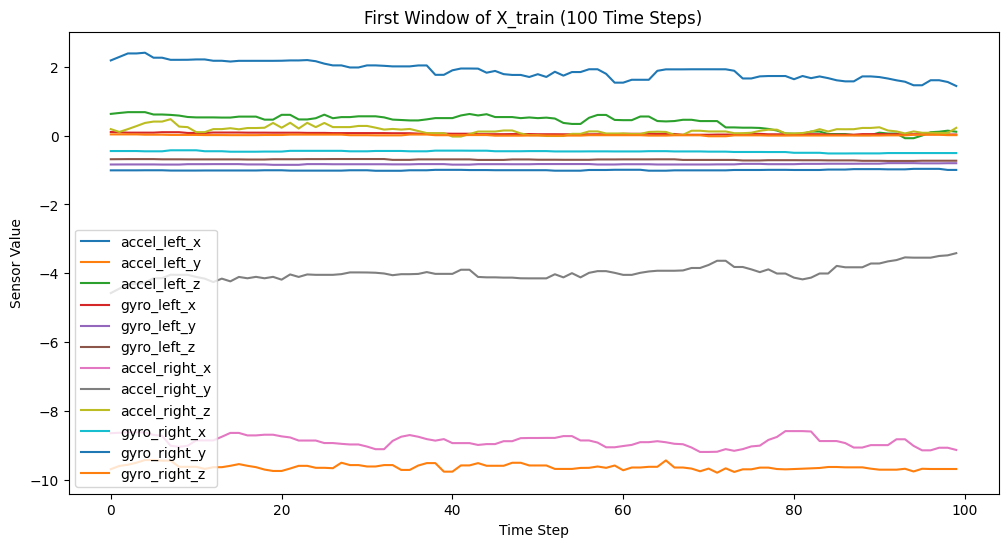

In [ ]:
plt.figure(figsize=(12, 6))
for i, feature in enumerate(features):
    plt.plot(X_train1[0, :, i], label=feature)  # First sequence, all time steps
plt.title("First Window of X_train (100 Time Steps)")
plt.xlabel("Time Step")
plt.ylabel("Sensor Value")
plt.legend()
plt.show()

In [ ]:

from sklearn.utils.class_weight import compute_class_weight
from torch.utils.data import DataLoader, TensorDataset
from model import *

def get_best_device():
    if torch.cuda.is_available():
        return torch.device("cuda")
    elif torch.backends.mps.is_available():
        return torch.device("mps")
    else:
        return torch.device("cpu")


def train_model(parcel , model_type='EnhancedLSTM',
                 hidden_size=64, learning_rate=0.001, weight_decay=1e-4, num_epochs=30, patience=7, batch_size=8):
    device = get_best_device()
    print(f"Using device: {device}")
    X_train, y_train, X_val, y_val, X_test, y_test = parcel
    encoder = LabelEncoder()
    y_train_enc = encoder.fit_transform(y_train)
    y_val_enc = encoder.transform(y_val)
    y_test_enc = encoder.transform(y_test)

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
    X_val = scaler.transform(X_val.reshape(-1, X_val.shape[-1])).reshape(X_val.shape)
    X_test = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

    X_train_t, y_train_t = to_tensor(X_train, y_train_enc)
    X_val_t, y_val_t = to_tensor(X_val, y_val_enc)
    X_test_t, y_test_t = to_tensor(X_test, y_test_enc)

    # Verify the split
    print(f"Train Subjects: {train_subjects}")
    print(f"Validation Subjects: {val_subjects}")
    print(f"Test Subjects: {test_subjects}")
    # (num_samples, window_size, num_features)
    print(f"Train shape: {X_train_t.shape}, Validation shape: {X_val_t.shape}, Test shape: {X_test_t.shape}")

    train_dataset = TensorDataset(X_train_t, y_train_t)
    val_dataset = TensorDataset(X_val_t, y_val_t)
    test_dataset = TensorDataset(X_test_t, y_test_t)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)#don't suffle timeseries data
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    input_size = X_train_t.shape[-1]
    num_classes = len(encoder.classes_)

    weights = compute_class_weight('balanced', classes=np.unique(y_train_enc), y=y_train_enc)
    weights = torch.tensor(weights, dtype=torch.float32)

    if model_type == 'EnhancedLSTM':
        model = EnhancedLSTMNet(input_size, hidden_size, num_classes)
    elif model_type == 'LSTM':
        model = LSTMNet(input_size, hidden_size, num_classes)
    else:
        model = RNNNet(input_size, hidden_size, num_classes)

    criterion = nn.CrossEntropyLoss(weight=weights)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=2)


    train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []
    best_loss = float("inf")
    trigger = 0

    for epoch in range(num_epochs):
      model.train() # trainign
      epoch_train_loss , correct_train , total_train = 0, 0, 0


      for X_batch, y_batch in train_loader:
          optimizer.zero_grad()
          outputs = model(X_batch)
          loss = criterion(outputs, y_batch)
          loss.backward()
          optimizer.step()

          epoch_train_loss += loss.item()
          _, predicted = torch.max(outputs.data, 1)
          total_train += y_batch.size(0)
          correct_train += (predicted == y_batch).sum().item()

      epoch_train_loss /= len(train_loader)
      epoch_train_acc = 100 * correct_train / total_train

      model.eval() # validation
      epoch_val_loss, correct_val, total_val = 0, 0, 0

      with torch.no_grad():
          for X_batch, y_batch in val_loader:
              val_out = model(X_batch)
              val_loss = criterion(val_out, y_batch)
              epoch_val_loss += val_loss.item()
              _, predicted = torch.max(val_out.data, 1)
              total_val += y_batch.size(0)
              correct_val += (predicted == y_batch).sum().item()

      epoch_val_loss /= len(val_loader)
      epoch_val_acc = 100 * correct_val / total_val

      train_losses.append(epoch_train_loss)
      val_losses.append(epoch_val_loss)
      train_accuracies.append(epoch_train_acc)
      val_accuracies.append(epoch_val_acc)

      print(f"Epoch {epoch+1}: train_loss={epoch_train_loss:.4f}, train_acc={epoch_train_acc:.2f}%, "
          f"val_loss={epoch_val_loss:.4f}, val_acc={epoch_val_acc:.2f}%, "
          f"lr={optimizer.param_groups[0]['lr']:.6f}")

      scheduler.step(epoch_val_loss)#scheduler with validation loss

      if epoch_val_loss < best_loss: # early stop
          best_loss = epoch_val_loss
          trigger = 0
          torch.save(model.state_dict(), "best_model.pth")  # Save best model

      else:
          trigger += 1
          if trigger > patience:
              print(f"Early stopping at epoch {epoch+1}")
              break

    model.load_state_dict(torch.load("best_model.pth")) # load the bes t model
    model.eval()

    all_preds, all_labels = [], []
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            preds = model(X_batch).argmax(dim=1).cpu().numpy()
            labels = y_batch.cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(labels)
        print(len(all_preds), len(all_preds))


    rresult = (test_loader, all_preds, all_labels)

    report = classification_report(all_labels, all_preds, target_names=[f"Class {i}" for i in range(num_classes)], output_dict=True)
    pred_df = pd.DataFrame(report).transpose()

    plt.figure(figsize=(10, 8))
    sns.heatmap(pred_df.iloc[:-1, :-1], annot=True, cmap="YlGnBu", fmt=".2f", vmin=0, vmax=1)
    plt.title("Classification Report Heatmap")
    plt.show()

    results_dict = {
    'train_losses': train_losses,
    'val_losses': val_losses,
    'train_accuracies': train_accuracies,
    'val_accuracies': val_accuracies
    }
    return model, rresult , results_dict, report

Using device: mps
Train Subjects: ['subject1', 'subject2', 'subject3', 'subject4', 'subject7', 'subject8']
Validation Subjects: ['subject5']
Test Subjects: ['subject6']
Train shape: torch.Size([6132, 100, 12]), Validation shape: torch.Size([986, 100, 12]), Test shape: torch.Size([916, 100, 12])
Epoch 1: train_loss=0.9772, train_acc=81.05%, val_loss=3.4382, val_acc=50.00%, lr=0.010000
Epoch 2: train_loss=0.8039, train_acc=52.64%, val_loss=0.7322, val_acc=50.00%, lr=0.010000
Epoch 3: train_loss=0.8646, train_acc=58.09%, val_loss=0.7494, val_acc=50.00%, lr=0.010000
Epoch 4: train_loss=0.7633, train_acc=48.45%, val_loss=0.7232, val_acc=50.00%, lr=0.010000
Epoch 5: train_loss=0.8386, train_acc=59.43%, val_loss=0.7281, val_acc=50.00%, lr=0.010000
Epoch 6: train_loss=0.7556, train_acc=42.04%, val_loss=0.7209, val_acc=50.00%, lr=0.010000
Epoch 7: train_loss=0.7524, train_acc=41.78%, val_loss=0.7198, val_acc=50.00%, lr=0.010000
Epoch 8: train_loss=0.7516, train_acc=41.78%, val_loss=0.7193, val_

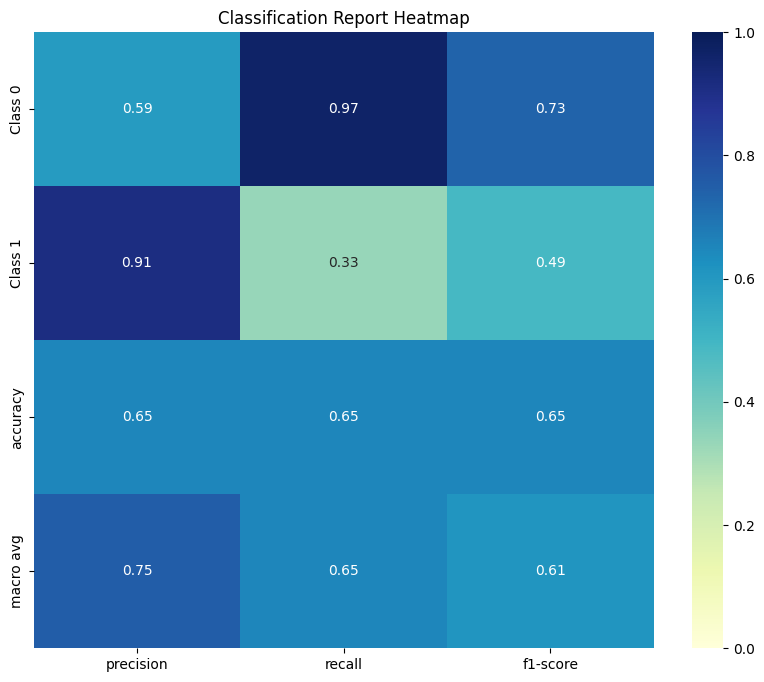

In [ ]:
binary_model, result1, results_dict1, report1   = train_model(parcel1, hidden_size=64, learning_rate=0.01, weight_decay=1e-4, num_epochs=300, patience=7, batch_size=8)

Using device: mps
Train Subjects: ['subject1', 'subject2', 'subject3', 'subject4', 'subject7', 'subject8']
Validation Subjects: ['subject5']
Test Subjects: ['subject6']
Train shape: torch.Size([3048, 100, 12]), Validation shape: torch.Size([490, 100, 12]), Test shape: torch.Size([455, 100, 12])
Epoch 1: train_loss=0.8502, train_acc=75.13%, val_loss=0.5649, val_acc=83.27%, lr=0.001000
Epoch 2: train_loss=0.4778, train_acc=85.63%, val_loss=0.4919, val_acc=85.71%, lr=0.001000
Epoch 3: train_loss=0.4500, train_acc=83.53%, val_loss=0.3867, val_acc=87.35%, lr=0.001000
Epoch 4: train_loss=0.3017, train_acc=86.71%, val_loss=0.6502, val_acc=84.49%, lr=0.001000
Epoch 5: train_loss=0.2633, train_acc=88.78%, val_loss=0.1683, val_acc=96.53%, lr=0.001000
Epoch 6: train_loss=0.1296, train_acc=95.44%, val_loss=0.8642, val_acc=85.51%, lr=0.001000
Epoch 7: train_loss=0.1021, train_acc=97.64%, val_loss=0.9103, val_acc=81.63%, lr=0.001000
Epoch 8: train_loss=0.0455, train_acc=99.34%, val_loss=0.9600, val_

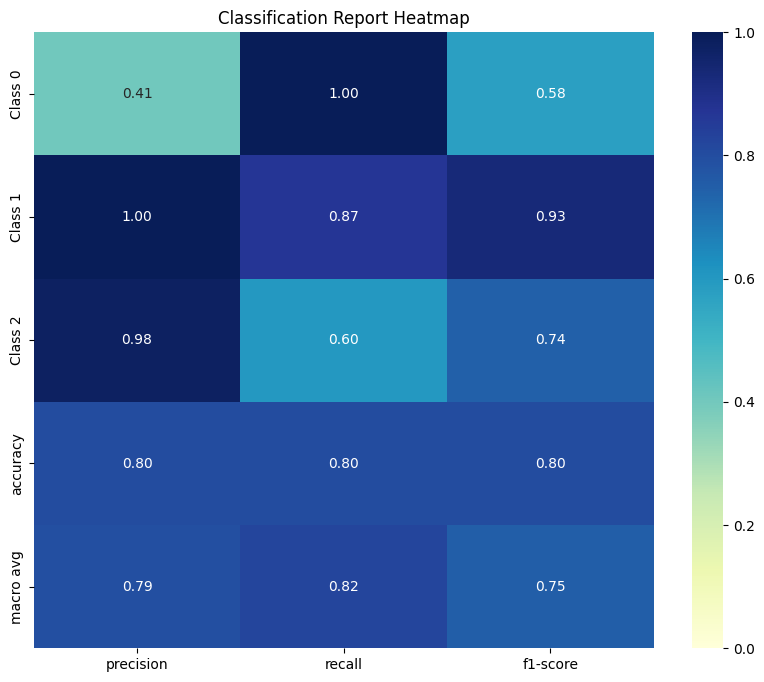

In [ ]:
multiclass_model,result2,  results_dict2, report2 = train_model(parcel2, hidden_size=64, learning_rate=0.001, weight_decay=1e-4, num_epochs=300, patience=7, batch_size=8)

In [ ]:
test_loader1, pred1, label1 = result1
test_loader2, pred2, label2 = result2

In [ ]:
pred1, label1 = [], []
with torch.no_grad():
    for X_batch, y_batch in test_loader1:
        preds = binary_model(X_batch).argmax(dim=1).cpu().numpy()
        labels = y_batch.cpu().numpy()
        pred1.extend(preds)
        label1.extend(labels)
    print(len(pred1), len(label1))


916 916


In [ ]:
pred2, label2 = [], []
with torch.no_grad():
    for X_batch, y_batch in test_loader2:
        preds = multiclass_model(X_batch).argmax(dim=1).cpu().numpy()
        labels = y_batch.cpu().numpy()
        pred2.extend(preds)
        label2.extend(labels)
    print(len(pred2), len(label2))

455 455


In [ ]:
r1 = pd.DataFrame([label1, pred1]).T

r1.columns = ['y_true', 'y_pred']
r2 = pd.DataFrame([label2, pred2]).T
r2.columns = ['y_true', 'y_pred']
r2 = r2+1 # Add 1 to make label consistant ### 2nd multiclass model label should start with 1 instead of 0

r1_0 = r1[r1['y_true']==0]
r1_1 = r1[r1['y_true']==1]
cascade_diff = r1_1.shape[0] - r2.shape[0] ##offset due to timeseries processing
r1_1 = r1_1[:-cascade_diff]
r1 = pd.concat([r1_0, r1_1])
r1 = r1.reset_index(drop=True)
offset = r1[r1.y_true==0].shape[0]+1
offset

459

In [ ]:
r1.value_counts()

y_true  y_pred
0       0         443
1       0         302
        1         153
0       1          15
Name: count, dtype: int64

In [ ]:
r2.value_counts()

y_true  y_pred
2       2         220
3       3          85
1       1          60
3       1          57
2       1          31
        3           2
Name: count, dtype: int64

In [ ]:
r1.y_pred.value_counts()

y_pred
0    745
1    168
Name: count, dtype: int64

In [ ]:
#create placeholder for multiclass prediction
ddd = pd.DataFrame({ 'y_true': np.nan,   'y_pred': np.nan   }, index=np.arange(1,offset ))

print(ddd.head())
dr2 = pd.concat([ddd,r2])
dr2 = dr2.reset_index(drop=True)

   y_true  y_pred
1     NaN     NaN
2     NaN     NaN
3     NaN     NaN
4     NaN     NaN
5     NaN     NaN


In [ ]:
r1.shape, dr2.shape

((913, 2), (913, 2))

In [ ]:
r1.to_csv('Cascade1_r1.csv', index=False)
dr2.to_csv('Cascade1_dr2.csv', index=False)

In [ ]:
indices_pred_1 = r1[(r1['y_pred'] == 1) & (r1.index >= offset)].index
indices_pred_2 = r1[(r1['y_pred'] == 1) & (r1.index < offset)].index
indices_pred_1

Index([465, 514, 712, 713, 714, 715, 716, 717, 718, 719,
       ...
       874, 875, 876, 877, 878, 879, 901, 902, 903, 904],
      dtype='int64', length=153)

In [ ]:
print(r1.loc[indices_pred_2, 'y_pred'].shape)
num_classes = 3
num_indices = len(indices_pred_2)
assignments = np.tile([1, 2, 3], num_indices // num_classes + 1)[:num_indices]
np.random.shuffle(assignments)
print(assignments.shape)
r1.loc[indices_pred_2, 'y_pred'] = assignments

(15,)
(15,)


In [ ]:
r1.loc[indices_pred_1, 'y_pred'] = dr2.loc[indices_pred_1, 'y_pred']
r1.loc[indices_pred_1, 'y_true'] = dr2.loc[indices_pred_1, 'y_true']

In [ ]:
r1.y_true.value_counts()

y_true
0    458
1    304
3     92
2     59
Name: count, dtype: int64

In [ ]:
r1.y_pred.value_counts()

y_pred
0    745
3     74
1     56
2     38
Name: count, dtype: int64

In [ ]:
result_report = classification_report(r1.y_true,r1.y_pred, output_dict=True , digits = 2)
report_df = pd.DataFrame(result_report).transpose()
report_df

,precision,recall,f1-score,support
0,0.594631,0.967249,0.736492,458.000000
1,0.035714,0.006579,0.011111,304.000000
2,0.868421,0.559322,0.680412,59.000000
3,0.905405,0.728261,0.807229,92.000000
accuracy,0.596933,0.596933,0.596933,0.596933
macro avg,0.601043,0.565353,0.558811,913.000000
weighted avg,0.457538,0.596933,0.498467,913.000000


In [ ]:
r1.to_csv('Cascade_Training_v2_resut.csv',index=False)

In [ ]:
a = classification_report(r2.y_true,r2.y_pred, output_dict=True , digits = 2)
d = pd.DataFrame(a).transpose()
d

,precision,recall,f1-score,support
1,0.405405,1.000000,0.576923,60.000000
2,1.000000,0.869565,0.930233,253.000000
3,0.977011,0.598592,0.742358,142.000000
accuracy,0.802198,0.802198,0.802198,0.802198
macro avg,0.794139,0.822719,0.749838,455.000000
weighted avg,0.914417,0.802198,0.825009,455.000000
